# 0.0 - Imports

In [2]:
import re
import io
import os
import tensorflow        as tf
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text     import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



## 0.1 Caminhos dos diretórios e arquivos

In [3]:
BASE_DIR = os.path.abspath('..')
DATA_DIR = os.path.join(BASE_DIR, 'data')
DATA_INTERIM_DIR = os.path.join(DATA_DIR, 'interim')
DATA_PROCESSED_DIR = os.path.join(DATA_DIR, 'external')
DATA_TRAIN = os.path.join(DATA_INTERIM_DIR, 'train_v1.csv')
DATA_VALIDATION =os.path.join(DATA_INTERIM_DIR, 'validation_v1.csv')


'd:\\projetos\\Projetos_NLP\\text_classifier\\data\\interim\\validation_v1.csv'

## 0.1 loading Data

In [4]:
df_train = pd.read_csv(DATA_TRAIN)

## 0.2 Helper Functions

In [5]:
# validação da acurácia do modelo
def plot_graphs(history, string):
    sns.set()
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 1.0 Preprocessing

In [6]:
df=df_train.copy()

In [7]:
df['review_text'] = df['review_text'].apply(str)

## 1.1 Configuration to model and tokenization

In [14]:
vocab_size = 30000 # Quantidade de palavras
embedding_dim = 16
max_length = 3000 # Tamanho de cada frase
trunc_type = 'post'
padding_type = 'post'
oov_tok = 'XXXX'
training_size = 85000

## 1.2 Train and Test

In [15]:
len(df)

100000

In [16]:
df.columns

Index(['Unnamed: 0', 'recommend_to_a_friend', 'review_text',
       'recommend_to_a_friend_num'],
      dtype='object')

In [17]:
sentences = df['review_text']
labels = df['recommend_to_a_friend_num']

In [20]:
# Divisão em 85 / 15 (treino e teste)
training_sentences = sentences[0:training_size]
training_labels = labels[0:training_size]
testing_sentences = sentences[training_size:]
testing_labels = labels[training_size:]

In [21]:
testing_labels_final = np.array(testing_labels)
training_labels_final = np.array(training_labels)

### Distribuition of the data train and test

In [22]:
training_labels.value_counts(normalize=True)

1    0.7358
0    0.2642
Name: recommend_to_a_friend_num, dtype: float64

In [23]:
testing_labels.value_counts(normalize=True)

1    0.7374
0    0.2626
Name: recommend_to_a_friend_num, dtype: float64

1- Sim (Recomendaria o produto para um amigo)

2 - Não (Não recomendaria um produto para um amigo)

## 1.3 Tokenização

In [24]:
tokenizer = Tokenizer(  num_words = vocab_size,
                        oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences) # Tokenizando as palavras do treinamento

word_index = tokenizer.word_index

# Criando a sequência de palavras para o treinamento, Substituindo as palavras pelos seus tokens.
training_sequences = tokenizer.texts_to_sequences(training_sentences) 
training_padded = pad_sequences(training_sequences,
                                maxlen= max_length,
                                padding=padding_type,
                                truncating= trunc_type)

# Repetindo o processo para os dados de teste.
testing_sequences = tokenizer.texts_to_sequences(testing_sentences) 
testing_padded = pad_sequences(testing_sequences,
                                maxlen= max_length,
                                padding=padding_type,
                                truncating= trunc_type)


# 2.0 Model

## 2.1 Build Model - Model_1

In [28]:
# Buid Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length), # Embedding das palavras tokenizadas
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

# Compile
loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']

model.compile(  loss= loss,
                optimizer = optimizer,
                metrics = metrics)


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3000, 16)          480000    
                                                                 
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 488,781
Trainable params: 488,781
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Mostrar modelo
dot_img_file = os.path.join(os.path.join(BASE_DIR,'docs'),'image_model.png')
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### 2.1.1 Model Fit

In [31]:
n_epochs = 15

In [32]:
history = model.fit(training_padded,
                    training_labels_final,
                    epochs = n_epochs,
                    validation_data = (testing_padded, testing_labels_final),
                    verbose = 2)

Epoch 1/15


KeyboardInterrupt: 

### 2.1.3 Save Model

In [33]:
VERSION_MODEL = '1'

In [25]:
path_model = os.path.join(os.path.join(BASE_DIR,'models'),VERSION_MODEL)
model.save(path_model)

INFO:tensorflow:Assets written to: D:\projetos\Projetos_NLP\text_classifier\models\model00_a\assets


# 3.0 Performance model

## 3.1 Load Model

In [ ]:
reconstructed_model = tf.keras.models.load_model(path_model)

## 3.2 Results

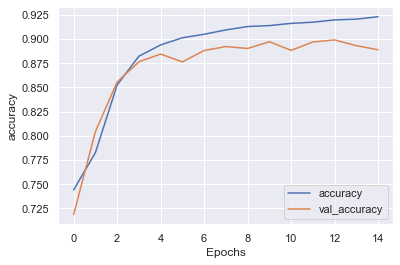

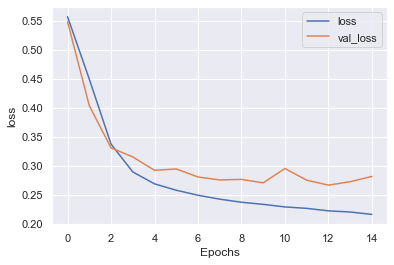

In [26]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# 4.0 Embeddings

In [29]:
# Obtendo os resultados da camada de embedding (primeira camada)
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # Shape: (Vocab_size, embedding_dim)
# 20000 Palavras e 16 dimensões

(30000, 16)


In [30]:
# Para sermos capazes de plotar as palavras como vetores, devemos obter o índice de palavras ao contrário
reverse_word_index = dict([(value, key) for (key,value) in word_index.items()])

## 4.1 Escrevendo os vetores em formatos de metadados

In [31]:
path_vecs = os.path.join(os.getenv('PATH_BASE'),'data\\external\\vecs.tsv')
path_meta = os.path.join(os.getenv('PATH_BASE'),'data\\external\\meta.tsv')

out_v = io.open(path_vecs, 'w', encoding='utf-8')
out_m = io.open(path_meta, 'w', encoding='utf-8')

In [32]:
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_m.close()
out_v.close()

O projecto TensorFlow lê esse tipo de arquivo e usa os dados para plotar um gráfico em 3D